# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=([1, 1, 1,])),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                        (0.4914, 0.4822, 0.4465),
                                        (0.2470, 0.2435, 0.2616)
                                       )
])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                        (0.4914, 0.4822, 0.4465),
                                        (0.2470, 0.2435, 0.2616)
                                       )
])

# Dataset and Creating Train/Test Split

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

batch_size=256
kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 2,
    'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


# The model
Let's start with the model we first saw

In [4]:
def get_layer(layer_type, in_channel=None, out_channel=None,
              dropout_value=0.05, norm='batch', group=1):
    norm_map = {'batch': nn.BatchNorm2d,
     'layer': nn.GroupNorm,
     'group': nn.GroupNorm}
    norm_layer = norm_map[norm]
    if layer_type == 'C':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel,
                      out_channels=out_channel,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(out_channel),
            nn.Dropout(dropout_value)
        )
    elif layer_type == 'c':
        return nn.Conv2d(in_channels=in_channel,
                        out_channels=out_channel,
                        kernel_size=(1, 1), padding=0, bias=False)
    elif layer_type == 'P':
        return nn.MaxPool2d(2, 2)
    elif layer_type == 'G':
        return nn.AdaptiveAvgPool2d(output_size=1)

In [5]:
class Net(nn.Module):
    def __init__(self, schema, channels, norm='batch', dropout_value=0.01):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        for layer_type, channel_in, channel_out in zip(
            schema, [3, *channels], channels):
            self.layers.append(get_layer(
                layer_type, channel_in, channel_out,
                dropout_value, norm))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
# !pip install torchsummary
from torchsummary import summary
model = Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
     8, 16, 16, 32, 32,
     8, 16, 32, 32, 10],
    norm='batch', dropout_value=0.05).to('cpu')
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          18,432
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11            [-1, 8, 16, 16]           1,152
             ReLU-12            [-1, 8, 16, 16]               0
      BatchNorm2d-13            [-1, 8, 16, 16]              16
          Dropout-14            [-1, 8,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

# Let's Train and test our model

In [7]:
from torch.optim.lr_scheduler import StepLR
from model import train, test
device = 'mps:0'
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=4, gamma=0.05)

EPOCHS =  20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=1.3730846643447876 Batch_id=195 Accuracy=36.74: 100%|██████████| 196/196 [00:24<00:00,  7.93it/s]



Test set: Average loss: 1.5087, Accuracy: 4397/10000 (43.97%)

EPOCH: 1


Loss=1.2381551265716553 Batch_id=195 Accuracy=52.22: 100%|██████████| 196/196 [00:21<00:00,  9.08it/s]



Test set: Average loss: 1.2295, Accuracy: 5502/10000 (55.02%)

EPOCH: 2


Loss=1.1241810321807861 Batch_id=195 Accuracy=57.56: 100%|██████████| 196/196 [00:21<00:00,  9.07it/s]



Test set: Average loss: 1.1922, Accuracy: 5649/10000 (56.49%)

EPOCH: 3


Loss=1.1141815185546875 Batch_id=195 Accuracy=60.31: 100%|██████████| 196/196 [00:21<00:00,  9.06it/s]



Test set: Average loss: 1.0708, Accuracy: 6056/10000 (60.56%)

EPOCH: 4


Loss=0.8517811894416809 Batch_id=195 Accuracy=63.78: 100%|██████████| 196/196 [00:21<00:00,  9.13it/s]



Test set: Average loss: 1.0051, Accuracy: 6371/10000 (63.71%)

EPOCH: 5


Loss=0.9186336398124695 Batch_id=195 Accuracy=64.58: 100%|██████████| 196/196 [00:21<00:00,  9.08it/s]



Test set: Average loss: 1.0077, Accuracy: 6365/10000 (63.65%)

EPOCH: 6


Loss=1.044646143913269 Batch_id=195 Accuracy=64.78: 100%|██████████| 196/196 [00:21<00:00,  9.08it/s] 



Test set: Average loss: 0.9984, Accuracy: 6395/10000 (63.95%)

EPOCH: 7


Loss=0.774104118347168 Batch_id=195 Accuracy=64.97: 100%|██████████| 196/196 [00:21<00:00,  8.94it/s] 



Test set: Average loss: 0.9975, Accuracy: 6398/10000 (63.98%)

EPOCH: 8


Loss=1.0025279521942139 Batch_id=195 Accuracy=65.35: 100%|██████████| 196/196 [00:21<00:00,  9.12it/s]



Test set: Average loss: 0.9805, Accuracy: 6471/10000 (64.71%)

EPOCH: 9


Loss=0.8803572654724121 Batch_id=195 Accuracy=65.38: 100%|██████████| 196/196 [00:21<00:00,  9.05it/s]



Test set: Average loss: 0.9858, Accuracy: 6438/10000 (64.38%)

EPOCH: 10


Loss=0.9042717218399048 Batch_id=195 Accuracy=65.59: 100%|██████████| 196/196 [00:21<00:00,  9.22it/s]



Test set: Average loss: 0.9812, Accuracy: 6470/10000 (64.70%)

EPOCH: 11


Loss=0.8340923190116882 Batch_id=195 Accuracy=65.24: 100%|██████████| 196/196 [00:21<00:00,  9.10it/s]



Test set: Average loss: 0.9879, Accuracy: 6443/10000 (64.43%)

EPOCH: 12


Loss=0.8498284220695496 Batch_id=195 Accuracy=65.34: 100%|██████████| 196/196 [00:21<00:00,  9.23it/s]



Test set: Average loss: 0.9916, Accuracy: 6427/10000 (64.27%)

EPOCH: 13


Loss=1.1208553314208984 Batch_id=195 Accuracy=65.45: 100%|██████████| 196/196 [00:21<00:00,  9.22it/s]



Test set: Average loss: 0.9815, Accuracy: 6477/10000 (64.77%)

EPOCH: 14


Loss=1.0308358669281006 Batch_id=195 Accuracy=65.36: 100%|██████████| 196/196 [00:21<00:00,  9.12it/s]



Test set: Average loss: 0.9889, Accuracy: 6451/10000 (64.51%)

EPOCH: 15


Loss=1.0360592603683472 Batch_id=195 Accuracy=65.39: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Average loss: 0.9826, Accuracy: 6460/10000 (64.60%)

EPOCH: 16


Loss=0.9888426661491394 Batch_id=195 Accuracy=65.35: 100%|██████████| 196/196 [00:21<00:00,  9.01it/s]



Test set: Average loss: 0.9798, Accuracy: 6474/10000 (64.74%)

EPOCH: 17


Loss=0.9101226925849915 Batch_id=195 Accuracy=65.41: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Average loss: 0.9856, Accuracy: 6450/10000 (64.50%)

EPOCH: 18


Loss=0.9554092288017273 Batch_id=195 Accuracy=65.38: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Average loss: 0.9804, Accuracy: 6469/10000 (64.69%)

EPOCH: 19


Loss=0.9124975204467773 Batch_id=195 Accuracy=65.34: 100%|██████████| 196/196 [00:21<00:00,  8.99it/s]



Test set: Average loss: 0.9947, Accuracy: 6410/10000 (64.10%)



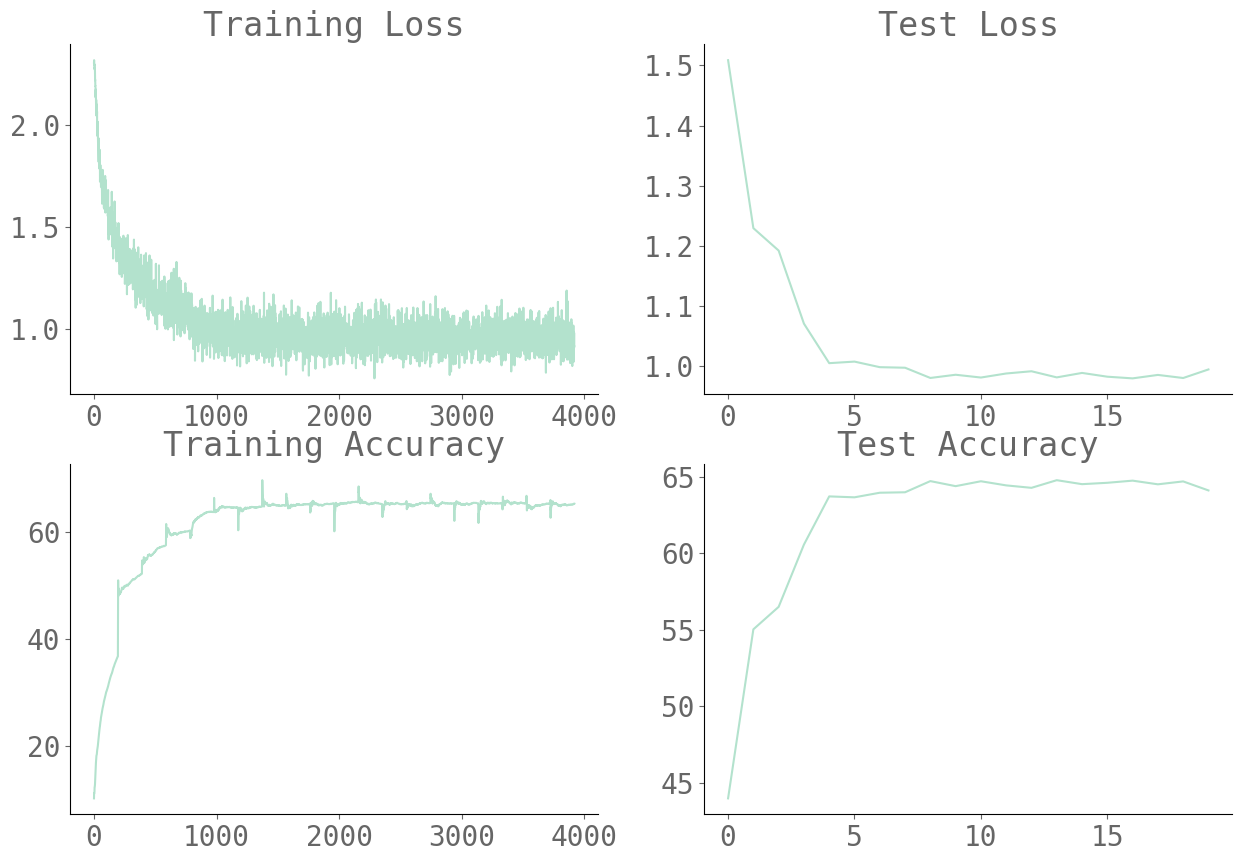

In [8]:
from model import plot_loss_n_acc
plot_loss_n_acc()

In [11]:
import pandas as pd
results_df = []
kwargs['shuffle'] = False
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred_label = output.argmax(dim=1)
    results_df.append(
        pd.DataFrame({"prediction": pred_label.cpu().numpy(),
                      "target": target.cpu().numpy()}))

df = pd.concat(results_df).reset_index(drop=True)

Files already downloaded and verified


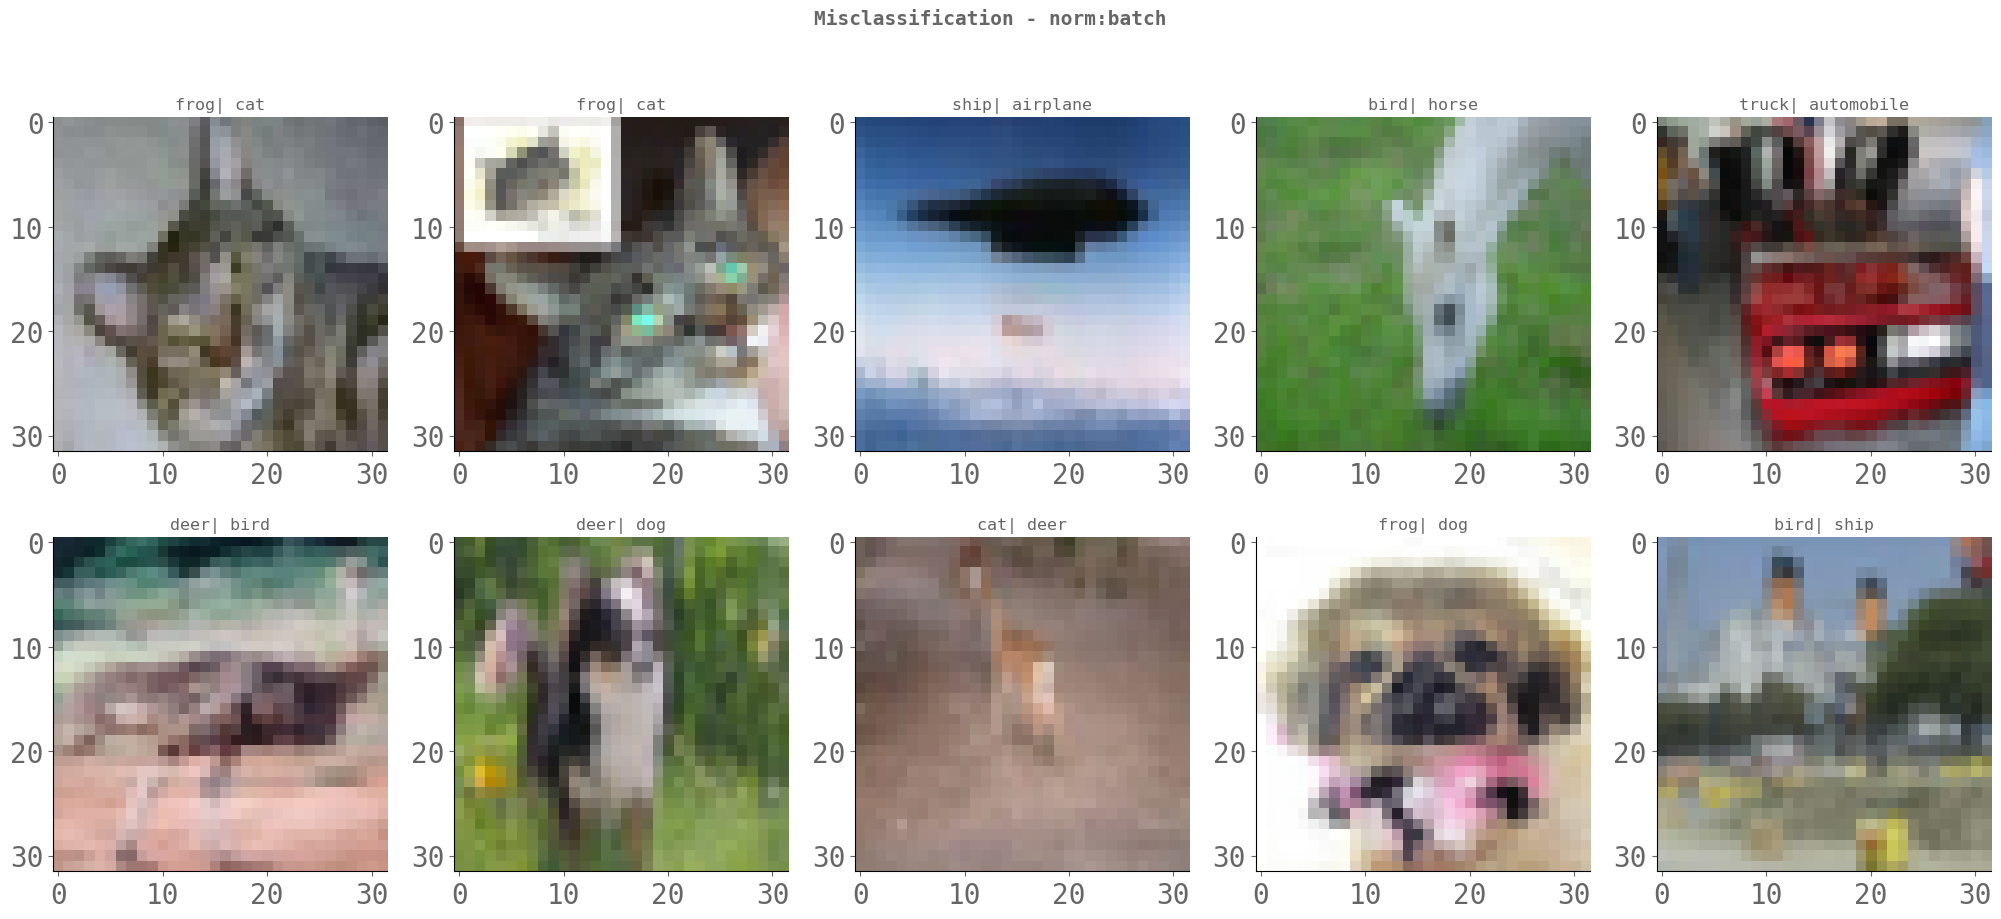

In [12]:
import matplotlib.pyplot as plt
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10), )
norm='batch'
fig.suptitle(f"Misclassification - norm:{norm}", weight='bold', size=14)
samples = df.query("prediction != target").sample(10)
axes = axes.ravel()

plot_test_data = datasets.CIFAR10('./data', train=False, download=True,)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

for (ix, row), ax in zip(samples.iterrows(), axes):
    img = plot_test_data[ix][0]
    ax.imshow(img, interpolation='nearest')
    ax.set_title(f'{class_labels[row.prediction]}| {class_labels[row.target]}', fontsize=12)